In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

In [3]:
def generate_synthetic_dataset():
    np.random.seed(42)
    portfolios = ["Skin/Body", "Fragrance + Color Cosmetics", "Hair/APDO"]
    geographies = ["North America", "Europe", "South America", "Asia"]
    categories = ["Fragrance", "Hair Dye", "Face Make-Up", "Make Up Brushes", "Tools"]
    brands = ["Bobbi Brown", "Aveda", "Elizabeth Arden", "Kilian", "Frederic Malle", "Balmain"]
    segments = ["Lipstick", "Mascara", "Toner", "Bronzer", "Hair Dye", "Face Make-Up", "Tools"]
    data = []
    for portfolio in portfolios:
        for geography in geographies:
            for category in categories:
                for brand in brands:
                    for segment in segments:
                        sales = round(np.random.uniform(500000, 5000000), 2)
                        margin = round(np.random.uniform(5, 20), 2)
                        trend = round(np.random.uniform(-5, 15), 2)
                        contribution = round(np.random.uniform(1, 15), 2)

                        data.append({
                            "Portfolio": portfolio,
                            "Geography": geography,
                            "Category": category,
                            "Brand": brand,
                            "Segment": segment,
                            "Initial Sales ($)": sales,
                            "Margin (%)": margin,
                            "Trend (%)": trend,
                            "Contribution (%)": contribution
                        })
    return pd.DataFrame(data)

In [4]:
df = generate_synthetic_dataset()

In [5]:
from scipy.optimize import linprog

def maximize_sales(df):
    initial_sales = df["Initial Sales ($)"].values
    trend = df["Trend (%)"].values / 100
    brands = df["Brand"].unique()

    # Objective: Maximize sales (minimize negative)
    c = -initial_sales * (1 + trend)

    # Constraints: Ensure that the sum of sales per brand is between reasonable bounds
    A_ub, b_ub = [], []

    for brand in brands:
        brand_indices = df[df["Brand"] == brand].index.tolist()
        row = [1 if i in brand_indices else 0 for i in range(len(df))]
        
        # Upper and lower bounds for total sales per brand (flexible)
        brand_sales = initial_sales[brand_indices].sum()
        max_brand_sales = brand_sales * (1 + 0.14)
        min_brand_sales = brand_sales * (1 - 0.01)

        # Upper bound constraint (sum of sales ≤ max_brand_sales)
        A_ub.append(row)
        b_ub.append(max_brand_sales)

        # Lower bound constraint (sum of sales ≥ min_brand_sales → -sum of sales ≤ -min_brand_sales)
        A_ub.append([-x for x in row])
        b_ub.append(-min_brand_sales)

    # Bounds per segment sales
    min_trend, max_trend = -0.01, 0.14
    bounds = [(sales * (1 + min_trend), sales * (1 + max_trend)) for sales in initial_sales]

    # Run optimization
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')

    if result.success:
        df["Optimized Sales ($)"] = result.x
        total_optimized_sales = df["Optimized Sales ($)"].sum()
        df["Optimized Contribution (%)"] = (df["Optimized Sales ($)"] / total_optimized_sales) * 100
        print("Optimization successful.")
    else:
        print("Optimization failed:", result.message)

    return df

# Apply the corrected function
df = maximize_sales(df)


Optimization successful.


In [6]:
def plot_sales_comparison(df):
    aggregated = df.groupby("Brand")["Initial Sales ($)", "Optimized Sales ($)"].sum().reset_index()
    aggregated.plot(x="Brand", kind="bar", figsize=(12, 6))
    plt.title("Initial vs Optimized Sales by Brand")
    plt.ylabel("Sales ($)")
    plt.show()

C:\Users\Shrey\AppData\Local\Temp\ipykernel_22180\3152782764.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  aggregated = df.groupby("Brand")["Initial Sales ($)", "Optimized Sales ($)"].sum().reset_index()


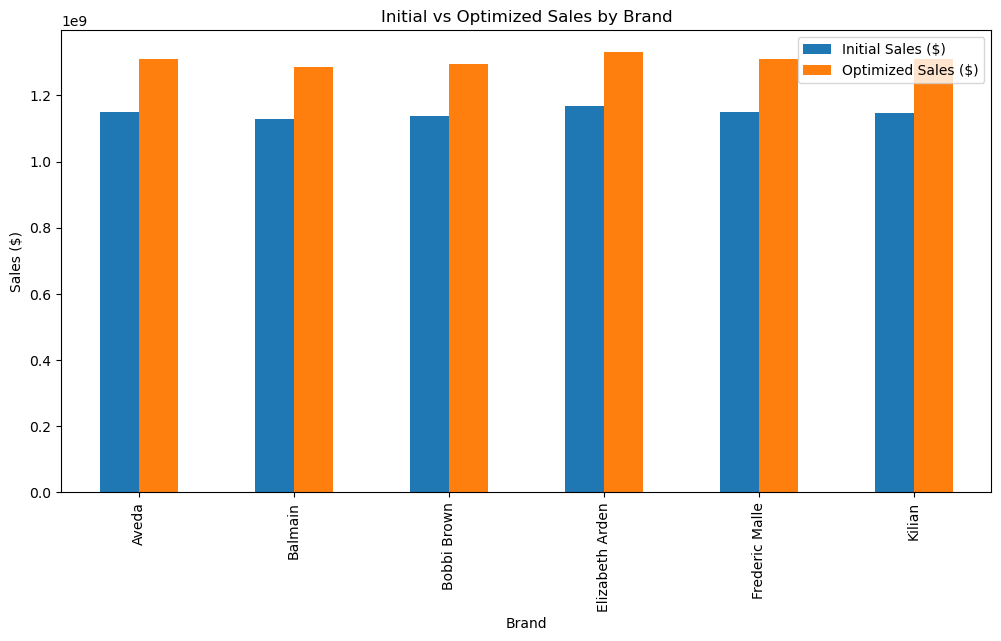

In [7]:
plot_sales_comparison(df)

In [8]:
df.to_csv("maximized_sales.csv", index=False)
print("Exported Objective 1 results to 'maximized_sales.csv'.")

Exported Objective 1 results to 'maximized_sales.csv'.


In [9]:

def maximize_margin(df):
    initial_sales = df["Initial Sales ($)"].values
    margin = df["Margin (%)"].values / 100
    trend = df["Trend (%)"].values / 100

    # Objective: Maximize total margin (minimize negative margin contribution)
    c = -(initial_sales * (1 + trend) * margin)

    # Constraints: Similar brand-level sales bounds as in sales optimization
    brands = df["Brand"].unique()
    A_ub, b_ub = [], []

    for brand in brands:
        brand_indices = df[df["Brand"] == brand].index.tolist()
        row = [1 if i in brand_indices else 0 for i in range(len(df))]

        brand_sales = initial_sales[brand_indices].sum()
        max_brand_sales = brand_sales * (1 + 0.14)
        min_brand_sales = brand_sales * (1 - 0.01)

        A_ub.append(row)
        b_ub.append(max_brand_sales)

        A_ub.append([-x for x in row])
        b_ub.append(-min_brand_sales)

    # Segment-level sales bounds
    min_trend, max_trend = -0.01, 0.14
    bounds = [(sales * (1 + min_trend), sales * (1 + max_trend)) for sales in initial_sales]

    # Run optimization
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')

    if result.success:
        df["Optimized Sales for Margin ($)"] = result.x
        df["Optimized Margin ($)"] = df["Optimized Sales for Margin ($)"] * margin
        total_optimized_margin = df["Optimized Margin ($)"].sum()
        df["Optimized Margin Contribution (%)"] = (df["Optimized Margin ($)"] / total_optimized_margin) * 100
        print("✅ Margin optimization successful.")
    else:
        print("❌ Margin optimization failed:", result.message)

    return df

# Run and export Objective 2 results
df = maximize_margin(df)

✅ Margin optimization successful.


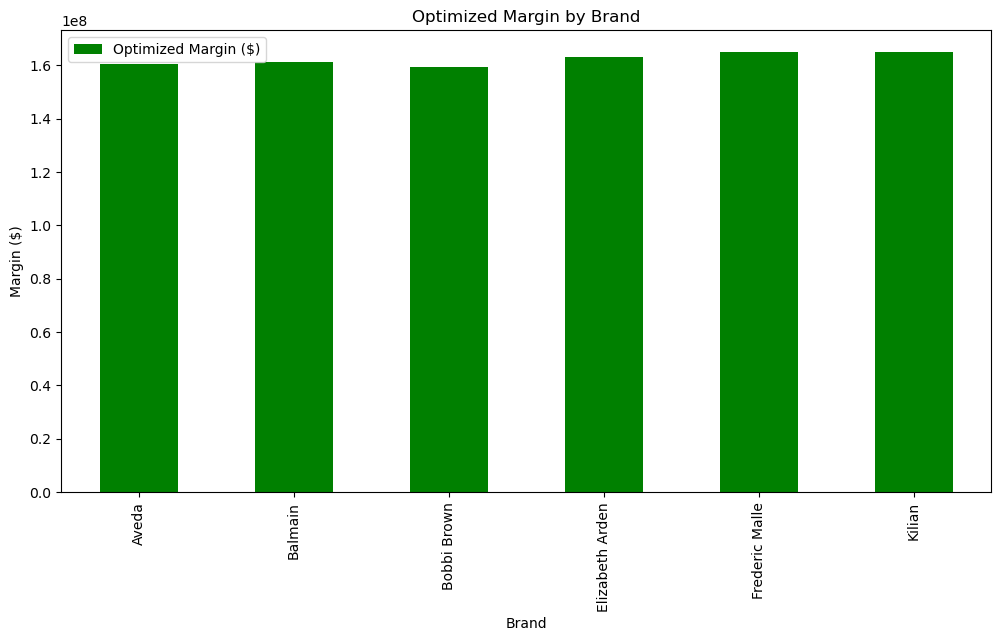

In [11]:
def plot_margin_comparison(df):
    aggregated = df.groupby("Brand")["Optimized Margin ($)"].sum().reset_index()
    aggregated.plot(x="Brand", kind="bar", figsize=(12, 6), color='green')
    plt.title("Optimized Margin by Brand")
    plt.ylabel("Margin ($)")
    plt.xlabel("Brand")
    plt.show()
plot_margin_comparison(df)

In [13]:
def hit_sales_target_maximize_margin(df, sales_target):
    initial_sales = df["Initial Sales ($)"].values
    margin = df["Margin (%)"].values / 100
    trend = df["Trend (%)"].values / 100

    # Objective: Maximize margin (minimize negative margin contribution)
    c = -(initial_sales * (1 + trend) * margin)

    # Constraints: Sum of optimized sales must meet the sales target
    A_eq = [[1] * len(df)]
    b_eq = [sales_target]

    # Brand-level constraints
    brands = df["Brand"].unique()
    A_ub, b_ub = [], []

    for brand in brands:
        brand_indices = df[df["Brand"] == brand].index.tolist()
        row = [1 if i in brand_indices else 0 for i in range(len(df))]

        brand_sales = initial_sales[brand_indices].sum()
        max_brand_sales = brand_sales * (1 + 0.14)
        min_brand_sales = brand_sales * (1 - 0.01)

        A_ub.append(row)
        b_ub.append(max_brand_sales)

        A_ub.append([-x for x in row])
        b_ub.append(-min_brand_sales)

    # Segment-level sales bounds
    min_trend, max_trend = -0.01, 0.14
    bounds = [(sales * (1 + min_trend), sales * (1 + max_trend)) for sales in initial_sales]

    # Run optimization
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result.success:
        df["Optimized Sales for Target ($)"] = result.x
        df["Optimized Margin for Target ($)"] = df["Optimized Sales for Target ($)"] * margin
        total_margin = df["Optimized Margin for Target ($)"].sum()
        df["Optimized Margin Contribution for Target (%)"] = (df["Optimized Margin for Target ($)"] / total_margin) * 100
        print("✅ Sales target achieved while maximizing margin.")
    else:
        print("❌ Optimization failed:", result.message)

    return df

# Example: Set a sales target (10% above initial total sales)
sales_target = df["Initial Sales ($)"].sum() * 1.10
df = hit_sales_target_maximize_margin(df, sales_target)

✅ Sales target achieved while maximizing margin.


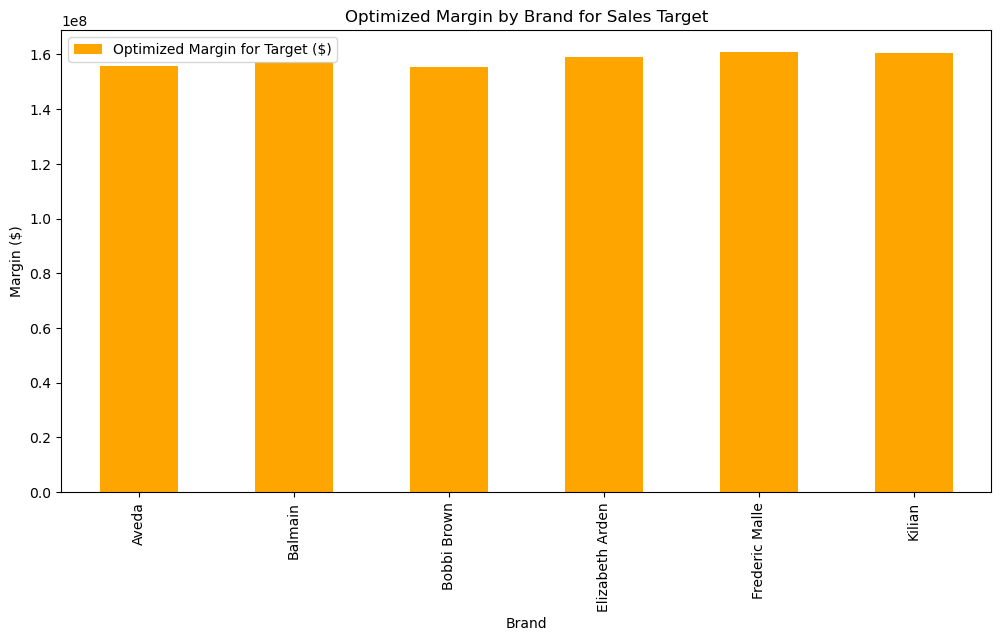

In [14]:
def plot_sales_target_margin(df):
    aggregated = df.groupby("Brand")["Optimized Margin for Target ($)"].sum().reset_index()
    aggregated.plot(x="Brand", kind="bar", figsize=(12, 6), color='orange')
    plt.title("Optimized Margin by Brand for Sales Target")
    plt.ylabel("Margin ($)")
    plt.xlabel("Brand")
    plt.show()

plot_sales_target_margin(df)

In [18]:
def calculate_max_possible_margin(df):
    """Calculate the maximum achievable margin without constraints."""
    initial_sales = df["Initial Sales ($)"].values
    margin = df["Margin (%)"].values / 100
    max_possible_sales = initial_sales * 1.3  # Assuming max trend of +30%
    max_margin = np.sum(max_possible_sales * margin)
    return max_margin

def hit_margin_target_maximize_sales(df, margin_target, min_trend=-0.10, max_trend=0.30):
    initial_sales = df["Initial Sales ($)"].values
    margin = df["Margin (%)"].values / 100
    trend = df["Trend (%)"].values / 100

    # Objective: Maximize sales
    c = -initial_sales * (1 + trend)

    # Constraint: Achieve margin target
    A_eq = [margin.tolist()]
    b_eq = [margin_target]

    # Relax brand-level constraints for diagnosis
    A_ub, b_ub = [], []

    # Expanded trend bounds
    bounds = [(sales * (1 + min_trend), sales * (1 + max_trend)) for sales in initial_sales]

    # Run optimization
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result.success:
        df["Optimized Sales for Margin Target ($)"] = result.x
        df["Achieved Margin ($)"] = df["Optimized Sales for Margin Target ($)"] * margin
        print("✅ Margin target achieved while maximizing sales.")
    else:
        print("❌ Optimization failed:", result.message)

    return result, df

# Step 1: Calculate max possible margin
max_margin = calculate_max_possible_margin(df)
print(f"🔔 Maximum possible margin: ${max_margin:,.2f}")

# Step 2: Set margin target to 90% of max possible margin for feasibility
feasible_margin_target = max_margin * 0.90
result, df = hit_margin_target_maximize_sales(df, feasible_margin_target)


🔔 Maximum possible margin: $1,110,562,901.29
✅ Margin target achieved while maximizing sales.


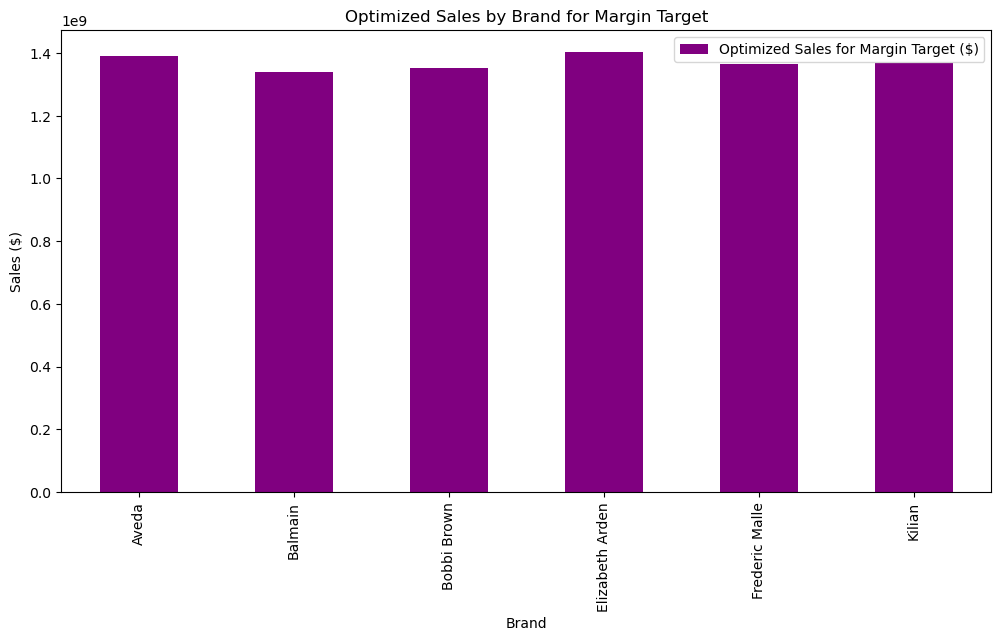

In [19]:
def plot_margin_target_sales(df):
    aggregated = df.groupby("Brand")["Optimized Sales for Margin Target ($)"].sum().reset_index()
    aggregated.plot(x="Brand", kind="bar", figsize=(12, 6), color='purple')
    plt.title("Optimized Sales by Brand for Margin Target")
    plt.ylabel("Sales ($)")
    plt.xlabel("Brand")
    plt.show()

plot_margin_target_sales(df)

In [20]:
df.to_csv("margin_target_max_sales.csv", index=False)
print("✅ Exported Objective 4 results to 'margin_target_max_sales.csv'.")


✅ Exported Objective 4 results to 'margin_target_max_sales.csv'.


✅ Exported 5-year projections to 'five_year_projections.csv'.


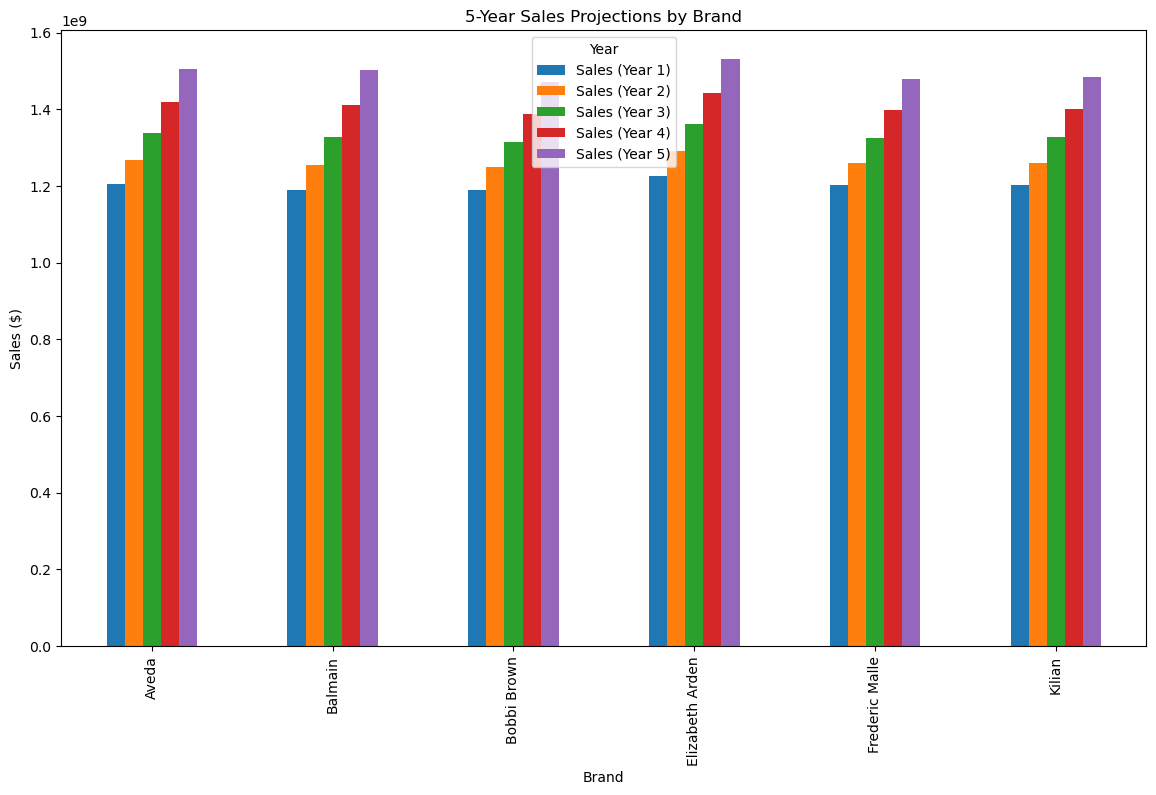

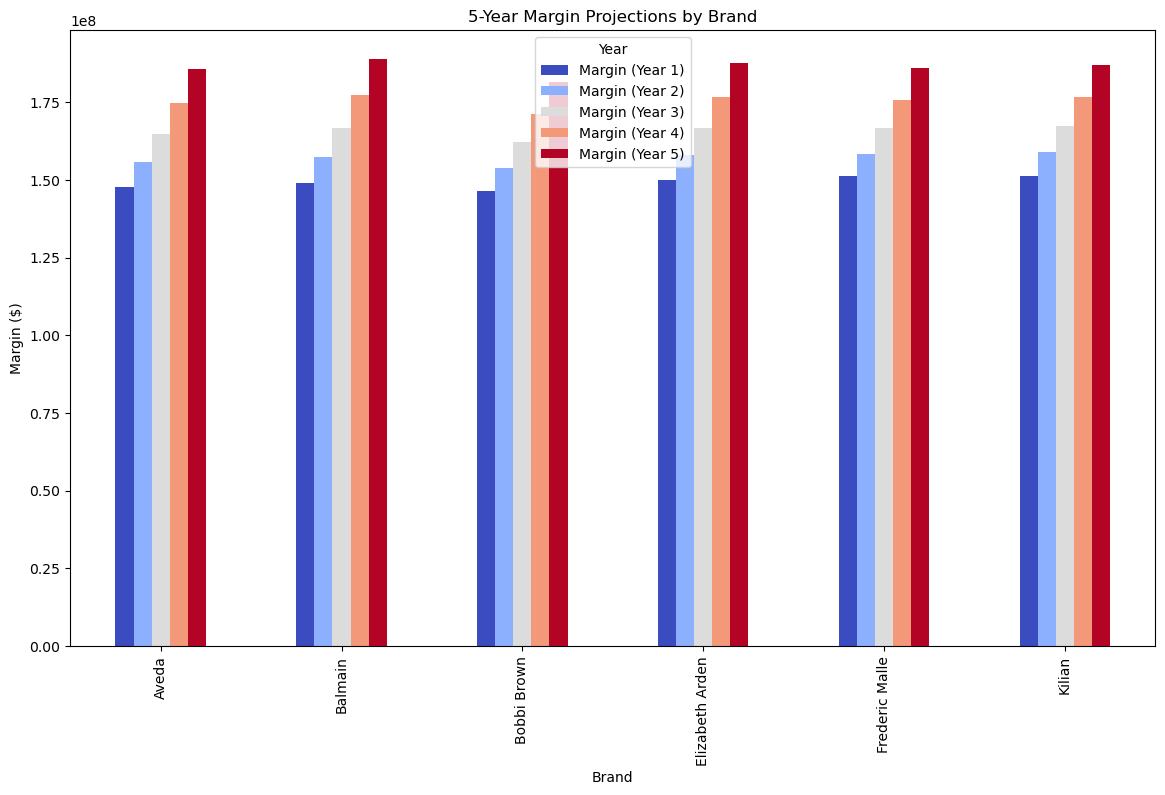

In [21]:
def project_5_years(df, annual_growth_col="Trend (%)"):
    """
    Project sales and margins for the next 5 years based on trend and margin percentages.
    """
    years = ["Year 1", "Year 2", "Year 3", "Year 4", "Year 5"]

    # Initialize projection columns
    for year in years:
        df[f"Sales ({year})"] = 0.0
        df[f"Margin ({year})"] = 0.0

    # Calculate projections
    for index, row in df.iterrows():
        sales = row["Initial Sales ($)"]
        margin_percentage = row["Margin (%)"] / 100
        trend = row[annual_growth_col] / 100

        for i, year in enumerate(years):
            # Compound annual growth
            projected_sales = sales * ((1 + trend) ** (i + 1))
            projected_margin = projected_sales * margin_percentage

            df.at[index, f"Sales ({year})"] = projected_sales
            df.at[index, f"Margin ({year})"] = projected_margin

    return df

# Run 5-Year Projections
df = project_5_years(df)

# Export projections
df.to_csv("five_year_projections.csv", index=False)
print("✅ Exported 5-year projections to 'five_year_projections.csv'.")

# Plot: 5-Year Sales Projections by Brand
def plot_5_year_sales(df):
    years = ["Year 1", "Year 2", "Year 3", "Year 4", "Year 5"]
    aggregated = df.groupby("Brand")[ [f"Sales ({year})" for year in years] ].sum().reset_index()

    aggregated.plot(x="Brand", kind="bar", figsize=(14, 8))
    plt.title("5-Year Sales Projections by Brand")
    plt.ylabel("Sales ($)")
    plt.xlabel("Brand")
    plt.legend(title="Year")
    plt.show()

plot_5_year_sales(df)

# Plot: 5-Year Margin Projections by Brand
def plot_5_year_margin(df):
    years = ["Year 1", "Year 2", "Year 3", "Year 4", "Year 5"]
    aggregated = df.groupby("Brand")[ [f"Margin ({year})" for year in years] ].sum().reset_index()

    aggregated.plot(x="Brand", kind="bar", figsize=(14, 8), colormap='coolwarm')
    plt.title("5-Year Margin Projections by Brand")
    plt.ylabel("Margin ($)")
    plt.xlabel("Brand")
    plt.legend(title="Year")
    plt.show()

plot_5_year_margin(df)
